In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wr
wr.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 105)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [180]:
df = pd.read_csv("loan_clean.csv")
#df = df.sample(frac = 0.01)
y = df['default']
y.value_counts()
dummy = df.columns.tolist()
dummy.remove('default')
X = pd.get_dummies(df[dummy],dtype='int')

In [181]:
df1 = pd.read_csv("loan_norm.csv")

In [182]:
best_features_names=['avg_cur_bal', 'last_fico_range_high', 'last_fico_range_low',
       'loan_amnt', 'pub_rec_bankruptcies', 'term', 'year', 'num_actv_rev_tl',
       'num_bc_tl', 'mths_since_recent_bc', 'application_type_Individual',
       'grade_C', 'initial_list_status_f', 'purpose_credit_card',
       'purpose_educational', 'purpose_moving', 'purpose_renewable_energy']

In [183]:
X=X[best_features_names]

In [184]:
avg_loan_amnt = np.mean(df1['loan_amnt'])
std = np.std(df1['loan_amnt'])

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1001, stratify=y)

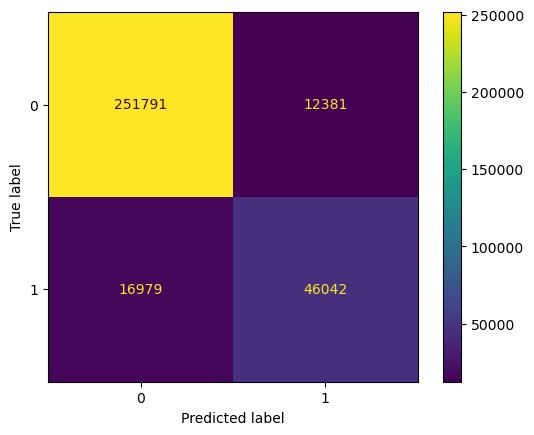

In [186]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_curve,roc_auc_score,precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

#balanced_accuracy_score=cross_val_score(log_reg,X,y,cv=10,scoring="balanced_accuracy")
# print(balanced_accuracy_score)

#print("accuracy: %0.2f(+- %0.2f)"%(balanced_accuracy_score.mean(),balanced_accuracy_score.std()))
log_reg.fit(X_train,y_train)
## draw confusion matrix
y_pred=log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


In [187]:
log_reg.intercept_

array([-2.68747548])

In [188]:
log_reg.coef_

array([[-1.55630954e-01, -2.88581930e+00,  2.83107687e-01,
         3.11668521e-01,  4.78598496e-03,  4.30454451e-01,
         2.91555753e-01, -2.35791600e-02,  1.00920762e-01,
         2.80064670e-02, -3.05471297e-01, -2.53425337e-02,
         6.66790543e-02, -5.10614455e-02, -1.78334214e-05,
         8.41849503e-02, -3.83717585e-06]])

In [189]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test,y_pred , target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.94      0.95      0.94    264172
     Default       0.79      0.73      0.76     63021

    accuracy                           0.91    327193
   macro avg       0.86      0.84      0.85    327193
weighted avg       0.91      0.91      0.91    327193



In [190]:
preds_lr = log_reg.predict_proba(X_test)
preds_df_lr = pd.DataFrame(preds_lr[:,1], columns = ['prob_default'])
preds_df_lr['loan_status'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

In [191]:
from sklearn.metrics import classification_report, precision_recall_fscore_support,accuracy_score
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.94      0.95      0.94    264172
     Default       0.79      0.73      0.76     63021

    accuracy                           0.91    327193
   macro avg       0.86      0.84      0.85    327193
weighted avg       0.91      0.91      0.91    327193



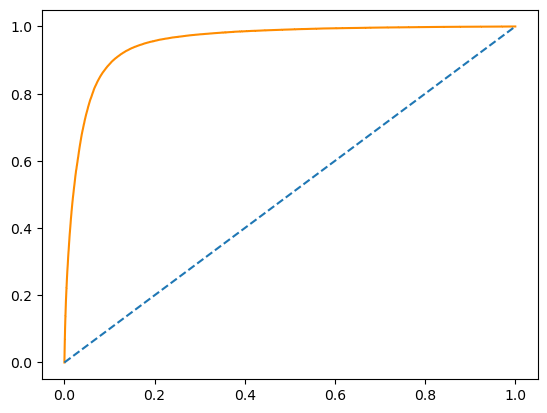

In [192]:
prob_default_lr = preds_lr[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_lr)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [193]:
auc = roc_auc_score(y_test, prob_default_lr)
auc

0.9528140402511047

In [194]:
num_defaults = preds_df_lr['loan_status'].value_counts()[1]
default_recall = precision_recall_fscore_support(y_test,preds_df_lr['loan_status'])[1][1]
print(num_defaults * avg_loan_amnt * (1 - default_recall))

233175806.9329517


In [195]:
thresh=[]
default=[]
non_defaut=[]
accs= []
for i in np.arange(0,1,0.01):
    thresh.append(i)
    preds_df_lr['loan_status'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > i else 0)
    accuracy = accuracy_score(y_test,preds_df_lr['loan_status'])
    accs.append(accuracy)
    default_recall = precision_recall_fscore_support(y_test,preds_df_lr['loan_status'])[1][1]
    default.append(default_recall)
    non_default_recall = precision_recall_fscore_support(y_test,preds_df_lr['loan_status'])[1][0]
    non_defaut.append(non_default_recall)
dict = {'thresh':thresh,'def_recalls':default,'nondef_recalls':non_defaut,'accuracy':accs}
results = pd.DataFrame(dict)

In [196]:
results

,thresh,def_recalls,nondef_recalls,accuracy
0,$0.00,$1.00,$0.00,$0.19
1,$0.01,$1.00,$0.37,$0.49
2,$0.02,$0.99,$0.52,$0.61
3,$0.03,$0.98,$0.61,$0.69
4,$0.04,$0.98,$0.68,$0.73
5,$0.05,$0.97,$0.72,$0.77
6,$0.06,$0.97,$0.75,$0.79
7,$0.07,$0.96,$0.78,$0.81
8,$0.08,$0.96,$0.80,$0.83
9,$0.09,$0.95,$0.82,$0.84


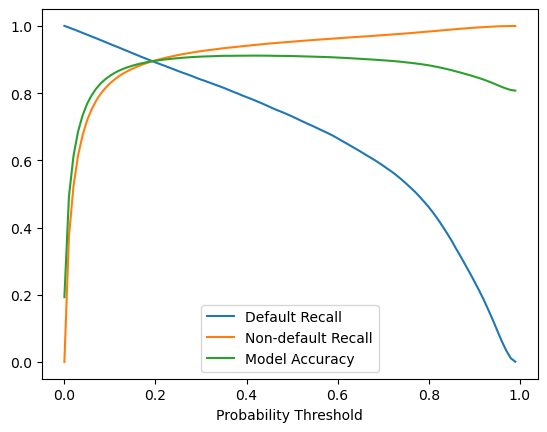

In [197]:
plt.plot(thresh,default)
plt.plot(thresh,non_defaut)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

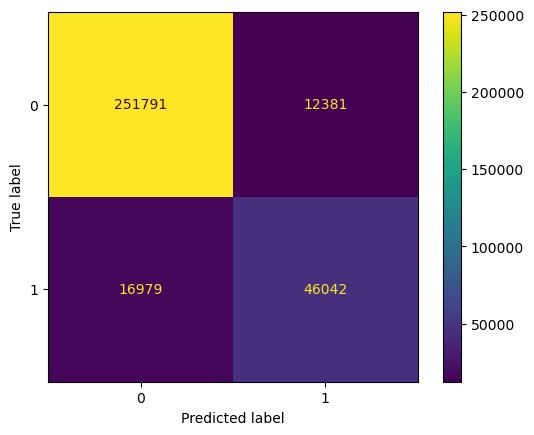

In [198]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
ada = RandomForestClassifier(max_depth=5)

##balanced_accuracy_score=cross_val_score(ada,X,y,cv=5,scoring="balanced_accuracy")
# print(balanced_accuracy_score)

#print("accuracy: %0.2f(+- %0.2f)"%(balanced_accuracy_score.mean(),balanced_accuracy_score.std()))
ada.fit(X_train,y_train)
## draw confusion matrix
y_pred_r=ada.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [199]:
preds_ada = ada.predict_proba(X_test)
preds_df_ada = pd.DataFrame(preds_ada[:,1], columns = ['prob_default'])
preds_df_ada['loan_status'] = preds_df_ada['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

In [200]:
from sklearn.metrics import classification_report, precision_recall_fscore_support,accuracy_score
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_ada['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.95      0.94      0.94    264172
     Default       0.75      0.80      0.78     63021

    accuracy                           0.91    327193
   macro avg       0.85      0.87      0.86    327193
weighted avg       0.91      0.91      0.91    327193



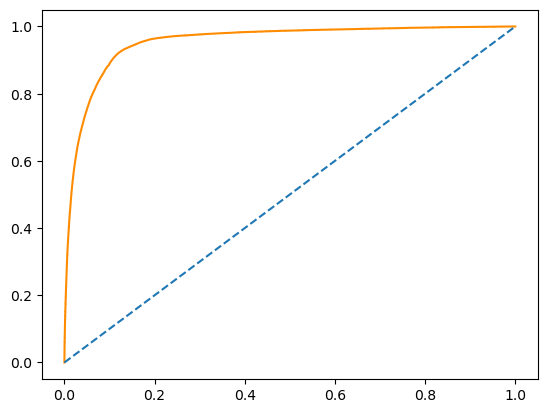

In [201]:
prob_default_ada = preds_ada[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_ada)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [202]:
auc = roc_auc_score(y_test, prob_default_ada)
auc

0.9541160814885721

In [203]:
num_defaults = preds_df_ada['loan_status'].value_counts()[1]
default_recall = precision_recall_fscore_support(y_test,preds_df_ada['loan_status'])[1][1]
print(num_defaults * avg_loan_amnt * (1 - default_recall))

198009807.87014273


In [204]:
thresh=[]
default=[]
non_defaut=[]
accs= []
for i in np.arange(0,1,0.01):
    thresh.append(i)
    preds_df_ada['loan_status'] = preds_df_ada['prob_default'].apply(lambda x: 1 if x > i else 0)
    accuracy = accuracy_score(y_test,preds_df_ada['loan_status'])
    accs.append(accuracy)
    default_recall = precision_recall_fscore_support(y_test,preds_df_ada['loan_status'])[1][1]
    default.append(default_recall)
    non_default_recall = precision_recall_fscore_support(y_test,preds_df_ada['loan_status'])[1][0]
    non_defaut.append(non_default_recall)
dict = {'thresh':thresh,'def_recalls':default,'nondef_recalls':non_defaut,'accuracy':accs}
results = pd.DataFrame(dict)

In [205]:
results

,thresh,def_recalls,nondef_recalls,accuracy
0,$0.00,$1.00,$0.00,$0.19
1,$0.01,$1.00,$0.00,$0.19
2,$0.02,$1.00,$0.11,$0.28
3,$0.03,$0.99,$0.54,$0.63
4,$0.04,$0.98,$0.71,$0.76
5,$0.05,$0.96,$0.80,$0.83
6,$0.06,$0.96,$0.82,$0.85
7,$0.07,$0.95,$0.83,$0.85
8,$0.08,$0.95,$0.83,$0.86
9,$0.09,$0.95,$0.84,$0.86


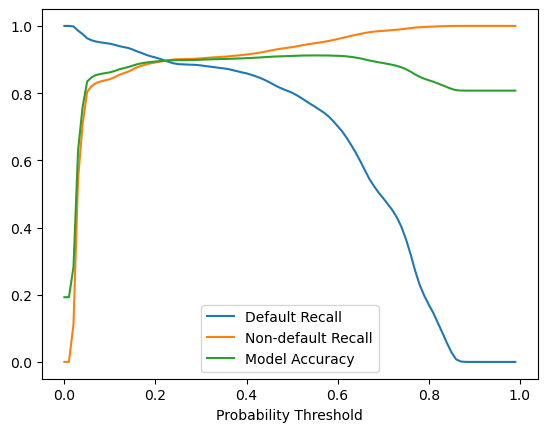

In [206]:
plt.plot(thresh,default)
plt.plot(thresh,non_defaut)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

In [207]:
# building the model

model = Sequential()
model.add(Dense(units=X_train.shape[1],activation='relu'))
model.add(Dense(units=13,activation='relu'))
model.add(Dense(units=8,activation='relu'))
model.add(Dense(units=4,activation='relu'))
model.add(Dense(units=2,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=X_train, 
          y=y_train, 
          epochs=50,
          batch_size=512,
          validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8433 - loss: 0.3585 - val_accuracy: 0.9134 - val_loss: 0.2231
Epoch 2/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.9126 - loss: 0.2206 - val_accuracy: 0.9145 - val_loss: 0.2076
Epoch 3/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.9137 - loss: 0.2068 - val_accuracy: 0.9150 - val_loss: 0.2024
Epoch 4/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.9136 - loss: 0.2037 - val_accuracy: 0.9150 - val_loss: 0.2005
Epoch 5/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9143 - loss: 0.2015 - val_accuracy: 0.9142 - val_loss: 0.2005
Epoch 6/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.9143 - loss: 0.2008 - val_accuracy: 0.9151 - val_loss: 0.1995
Epoch 7/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.9147 - loss: 0.2000 - val_accuracy: 0.9149 - val_loss: 0.1992
Epoch 8/50
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.9146 - l

In [208]:
y_pred_m = np.ravel((model.predict(X_test) > 0.3).astype("int32"))

10225/10225 ━━━━━━━━━━━━━━━━━━━━ 5s 529us/step


In [246]:
preds_m = np.ravel(model.predict(X_test))
preds_df_m = pd.DataFrame(preds_m, columns = ['prob_default'])
preds_df_m['loan_status'] = preds_df_m['prob_default'].apply(lambda x: 1 if x > 0.25 else 0)

10225/10225 ━━━━━━━━━━━━━━━━━━━━ 6s 577us/step


In [250]:
from sklearn.metrics import classification_report, precision_recall_fscore_support,accuracy_score
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_m['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.97      0.90      0.94    264172
     Default       0.68      0.90      0.78     63021

    accuracy                           0.90    327193
   macro avg       0.83      0.90      0.86    327193
weighted avg       0.92      0.90      0.90    327193



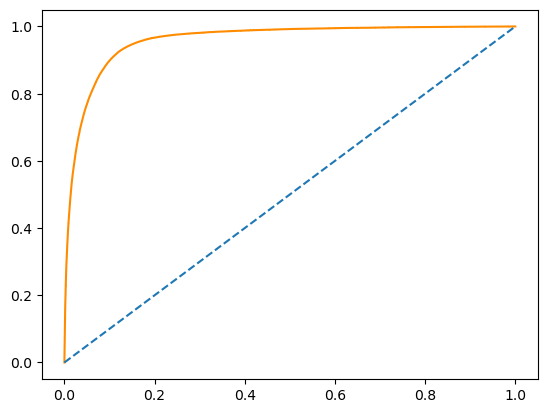

In [252]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_curve,roc_auc_score,precision_recall_fscore_support
prob_default_m = preds_m
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_m)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [254]:
auc = roc_auc_score(y_test, prob_default_m)
auc

0.9585813029018038

In [256]:
num_defaults = preds_df_m['loan_status'].value_counts()[1]
default_recall = precision_recall_fscore_support(y_test,preds_df_m['loan_status'])[1][1]
print(num_defaults * avg_loan_amnt * (1 - default_recall))

126559581.29496956


In [214]:
thresh=[]
default=[]
non_defaut=[]
accs= []
for i in np.arange(0,1,0.01):
    thresh.append(i)
    preds_df_m['loan_status'] = preds_df_m['prob_default'].apply(lambda x: 1 if x > i else 0)
    accuracy = accuracy_score(y_test,preds_df_m['loan_status'])
    accs.append(accuracy)
    default_recall = precision_recall_fscore_support(y_test,preds_df_m['loan_status'])[1][1]
    default.append(default_recall)
    non_default_recall = precision_recall_fscore_support(y_test,preds_df_m['loan_status'])[1][0]
    non_defaut.append(non_default_recall)
dict = {'thresh':thresh,'def_recalls':default,'nondef_recalls':non_defaut,'accuracy':accs}
results = pd.DataFrame(dict)

In [215]:
results

,thresh,def_recalls,nondef_recalls,accuracy
0,$0.00,$1.00,$0.00,$0.19
1,$0.01,$0.99,$0.56,$0.64
2,$0.02,$0.98,$0.69,$0.75
3,$0.03,$0.98,$0.75,$0.79
4,$0.04,$0.97,$0.78,$0.81
5,$0.05,$0.97,$0.80,$0.83
6,$0.06,$0.96,$0.81,$0.84
7,$0.07,$0.96,$0.82,$0.85
8,$0.08,$0.96,$0.83,$0.86
9,$0.09,$0.95,$0.84,$0.86


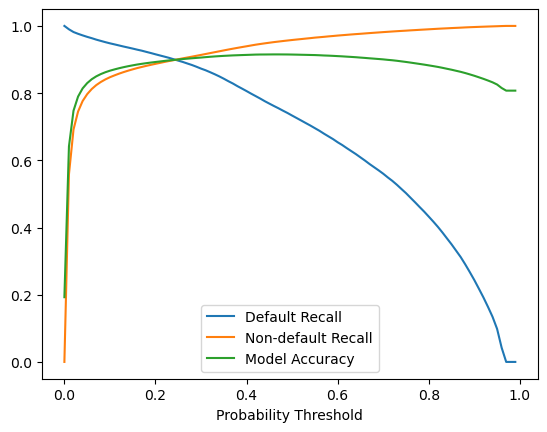

In [216]:
plt.plot(thresh,default)
plt.plot(thresh,non_defaut)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

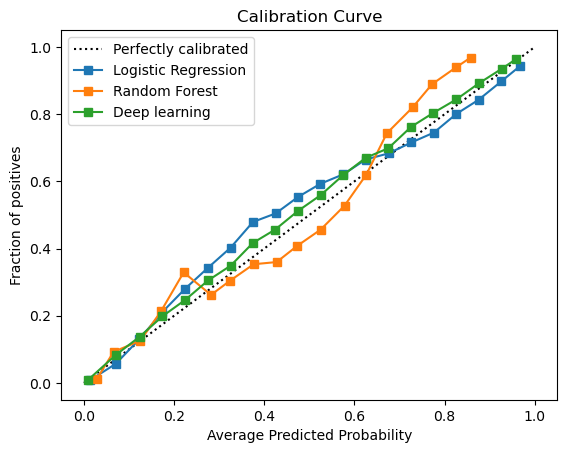

In [217]:
from sklearn.calibration import calibration_curve
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, preds_lr[:,1], n_bins=20)
frac_of_pos_ada, mean_pred_val_ada = calibration_curve(y_test, preds_ada[:,1], n_bins=20)
frac_of_pos_m, mean_pred_val_m = calibration_curve(y_test, preds_m, n_bins=20)
# Create the calibration curve plot with the guideline
# Add the calibration curve for the logistic regression to the plot
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,'s-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_ada, frac_of_pos_ada,'s-', label='%s' % 'Random Forest')
plt.plot(mean_pred_val_m, frac_of_pos_m,'s-', label='%s' % 'Deep learning')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [218]:
threshold = np.quantile(preds_m,0.85)

In [219]:
preds_df_m['loan_status'] = preds_df_m['prob_default'].apply(lambda x: 1 if x > threshold else 0)

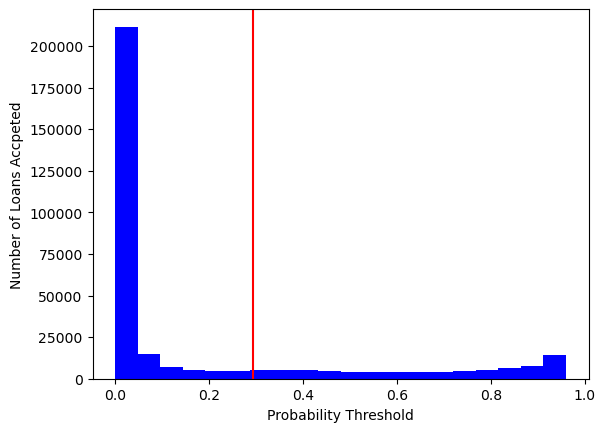

In [220]:
# Plot the predicted probabilities of default
plt.hist(preds_m, color = 'blue', bins = 20)

# Calculate the threshold with quantile
threshold = np.quantile(preds_m, 0.76)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold,color='r', linestyle='-', label='Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Number of Loans Accpeted')
plt.show()

In [221]:
col = {'true_loan_status':y_test,'prob_default':preds_m,'pred_loan_status':y_pred_m,'loan_amnt':X_test['loan_amnt']*std+avg_loan_amnt}
test_pred_df = pd.DataFrame(col)

In [222]:
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

0.032098577317272683


In [223]:
# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

pred_loan_status                 0               1
true_loan_status                                  
0                $3,572,782,768.98 $337,306,879.62
1                  $118,484,425.44 $814,308,450.96


In [224]:
# Print the first five rows of the data frame
test_pred_df['loss_given_default']=1.0
print(test_pred_df.head())

# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * test_pred_df['loss_given_default']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

        true_loan_status  prob_default  pred_loan_status  loan_amnt  \
12212                  1         $0.02                 0 $11,200.00   
420471                 0         $0.01                 0  $9,000.00   
184789                 0         $0.00                 0 $12,000.00   
20464                  0         $0.01                 0 $17,000.00   
158088                 0         $0.01                 0 $15,000.00   

        loss_given_default  
12212                $1.00  
420471               $1.00  
184789               $1.00  
20464                $1.00  
158088               $1.00  
Total expected loss:  $975,408,861.79


In [225]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [226]:
# Populate the arrays for the strategy table with a for loop
thresholds=[]
bad_rates = []
for rate in accept_rates:
  	# Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_m['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_m['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [227]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0             $1.00      $0.96     $0.19
1             $0.95      $0.90     $0.15
2             $0.90      $0.77     $0.11
3             $0.85      $0.60     $0.08
4             $0.80      $0.41     $0.05
5             $0.75      $0.26     $0.03
6             $0.70      $0.11     $0.01
7             $0.65      $0.05     $0.01
8             $0.60      $0.03     $0.01
9             $0.55      $0.02     $0.01
10            $0.50      $0.01     $0.01
11            $0.45      $0.01     $0.00
12            $0.40      $0.01     $0.00
13            $0.35      $0.01     $0.00
14            $0.30      $0.01     $0.00
15            $0.25      $0.00     $0.00
16            $0.20      $0.00     $0.00
17            $0.15      $0.00     $0.00
18            $0.10      $0.00     $0.00
19            $0.05      $0.00     $0.00


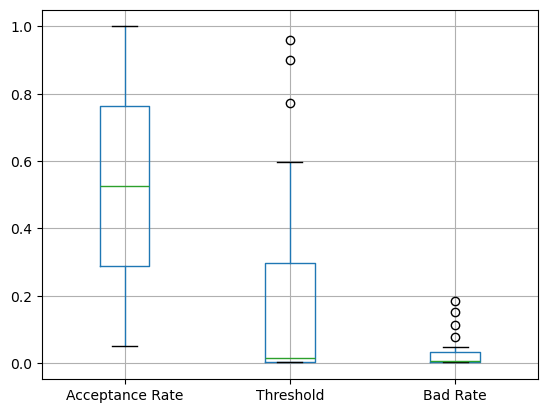

In [228]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

In [229]:
col = {'true_loan_status':y_test,'prob_default':preds_ada[:,1],'pred_loan_status':y_pred_r,'loan_amnt':X_test['loan_amnt']*std+avg_loan_amnt}
test_pred_df = pd.DataFrame(col)

In [230]:
# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

pred_loan_status                 0               1
true_loan_status                                  
0                $3,663,203,925.14 $246,885,723.46
1                  $185,652,735.58 $747,140,140.82


In [231]:
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

0.04823581440959871


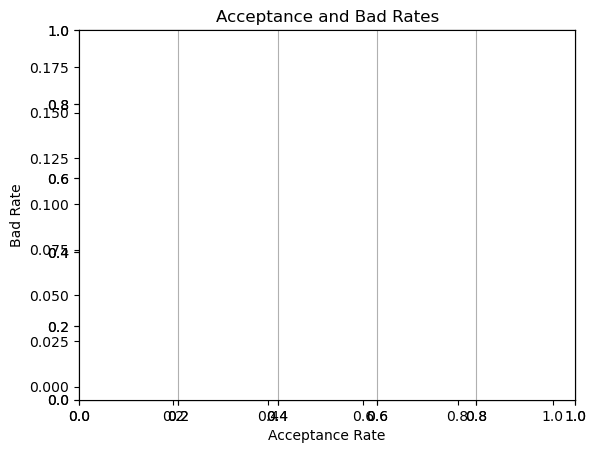

In [232]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [233]:
# Check the statistics of the probabilities of default
print(test_pred_df['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.75)

# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(test_pred_df['pred_loan_status'].value_counts())

count   $327,193.00
mean          $0.19
std           $0.27
min           $0.01
25%           $0.02
50%           $0.03
75%           $0.27
max           $0.89
Name: prob_default, dtype: float64
pred_loan_status
0    245395
1     81798
Name: count, dtype: int64


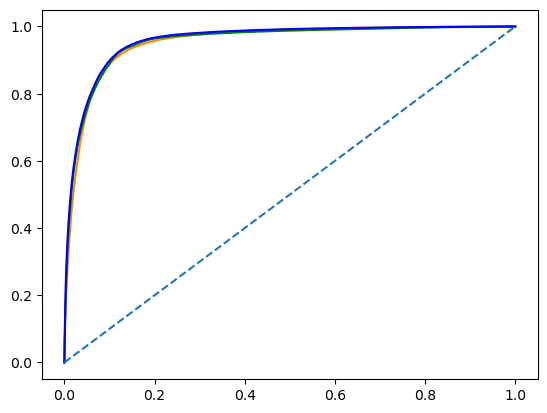

In [234]:
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_lr)
plt.plot(fallout, sensitivity, color = 'darkorange')
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_ada)
plt.plot(fallout, sensitivity, color = 'green')
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_m)
plt.plot(fallout, sensitivity, color = 'blue')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [235]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.2 else 0)
y_pred_model2 = preds_df_ada['prob_default'].apply(lambda x: 1 if x > 0.24 else 0)

# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      2.6177875437633817e-20
statistic   4108.0
[[ 78267   4989]
 [  4108 239829]]


In [236]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = y_pred_m
y_pred_model2 = preds_df_ada['prob_default'].apply(lambda x: 1 if x > 0.24 else 0)

# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      0.0
statistic   1802.0
[[ 76003   1802]
 [  6372 243016]]


In [237]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.2 else 0)
y_pred_model2 = y_pred_m

# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      0.0
statistic   1167.0
[[ 76638   6618]
 [  1167 242770]]


In [238]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = y_test
y_pred_model2 = y_pred_m
#y_pred_model2=preds_df_ada['prob_default'].apply(lambda x: 1 if x > 0.24 else 0)
#y_pred_model2=preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.2 else 0)
# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      0.0
statistic   8005.0
[[ 55016   8005]
 [ 22789 241383]]


In [239]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = y_test
y_pred_model2=preds_df_ada['prob_default'].apply(lambda x: 1 if x > 0.24 else 0)
#y_pred_model2=preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.2 else 0)
# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      5.6784194758403336e-176
statistic   14561.0
[[ 4862 14561]
 [19794 58847]]


In [240]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = y_test
y_pred_model2=preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.2 else 0)
# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      4.194957378618405e-197
statistic   14507.0
[[ 4916 14507]
 [20065 58576]]


In [241]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Assuming you have the true labels and predictions from two models
#y_true =  True labels
y_pred_model1 = y_test
y_pred_model2=preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.2 else 0)
# Create a contingency table
contingency_table = np.array([
    [np.sum((y_pred_model1 == 1) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 1) & (y_pred_model2 == 0))],
    [np.sum((y_pred_model1 == 0) & (y_pred_model2 == 1)), np.sum((y_pred_model1 == 0) & (y_pred_model2 == 0))]
])

# Perform McNemar's test
mec = mcnemar(contingency_table, exact=True)
print(mec)
print(contingency_table)

pvalue      4.194957378618405e-197
statistic   14507.0
[[ 4916 14507]
 [20065 58576]]


In [242]:
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

# Train a machine learning model
model1 = log_reg.fit(X_train, y_train)

# Calculate feature importance using permutation importance
result = permutation_importance(model1, X_test, y_test, n_repeats=30, random_state=0)

# Print feature importances
for i in range(X.shape[1]):
    print(f"Feature {i}: {result.importances_mean[i]}")

Feature 0: 0.0005721393795099654
Feature 1: 0.21895945206651732
Feature 2: 8.975334639393928e-05
Feature 3: 0.00315573173427713
Feature 4: 6.5201068890038035e-06
Feature 5: 0.006385425931076365
Feature 6: 0.0028589649941573756
Feature 7: -6.21447687858175e-05
Feature 8: 0.00021159784388217196
Feature 9: -3.881501132360077e-05
Feature 10: 4.8595171657106476e-05
Feature 11: -1.7828417274619774e-05
Feature 12: 4.278820145908746e-06
Feature 13: -8.353886951536123e-06
Feature 14: 0.0
Feature 15: -6.2144768785817504e-06
Feature 16: 0.0
